In [4]:
%load_ext autoreload

%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


try:
    import jupyter_black
except:
    print("Jupyter-Black not found")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Applied Machine Learning - LE3


- Pre-Processing and Pipelines
- Model Selection
- Generalization

## Imports

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import neighbors
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


## Parameters

In [26]:
sns.set(rc={'figure.figsize':(16,8)})
sns.set_theme(context='notebook', style='whitegrid', palette='deep')


POINT_SIZES = 120

## Functions

In [18]:
def true_function(x: np.ndarray) -> np.ndarray:
    """ Apply true function to input data """
    return (np.sin(x * 3.0) + 1.0 + (0.5 * x) ** 2).ravel()
    

def apply_noise(x: np.ndarray, scale: float=0.5, seed: int=123) -> np.ndarray:
    """ Add random noise to inputs """
    rng = np.random.default_rng(seed)
    return x + rng.normal(loc=0.0, scale=scale, size=x.shape)

## Create Dataset

In [43]:
X_MIN, X_MAX = 0, 5
NUM_SAMPLES = 50
NUM_TRAINING = 25
NUM_GRID_SAMPLES = 10000
RANDOM_SEED = 123

x_grid = np.linspace(X_MIN, X_MAX, NUM_GRID_SAMPLES).reshape(-1, 1)
y_grid = true_function(x_grid)


rng = np.random.default_rng(RANDOM_SEED)

id_random  = rng.choice(range(0, NUM_GRID_SAMPLES), size=NUM_SAMPLES, replace=False)
id_random.sort()


x = x_grid[id_random]
y = apply_noise(y_grid[id_random], scale=0.5, seed=RANDOM_SEED)

In [44]:
# Train-Test Split
indices = np.arange(0, x.shape[0])
x_train, x_test, y_train, y_test, i_train, i_test = model_selection.train_test_split(
    x, y, indices, random_state=RANDOM_SEED, train_size=NUM_TRAINING)

In [56]:

kernel_scale = 0.1
kernel = RBF(length_scale=kernel_scale)
model = Pipeline([
        ('gp', GaussianProcessRegressor(kernel=kernel, alpha=0.01, optimizer=None, normalize_y=True))
        ])

In [57]:
model = model.fit(X=x_train, y=y_train)
y_grid_hat = model.predict(X=x_grid)
#y_pred = model.predict(X=x)


(50, 1)

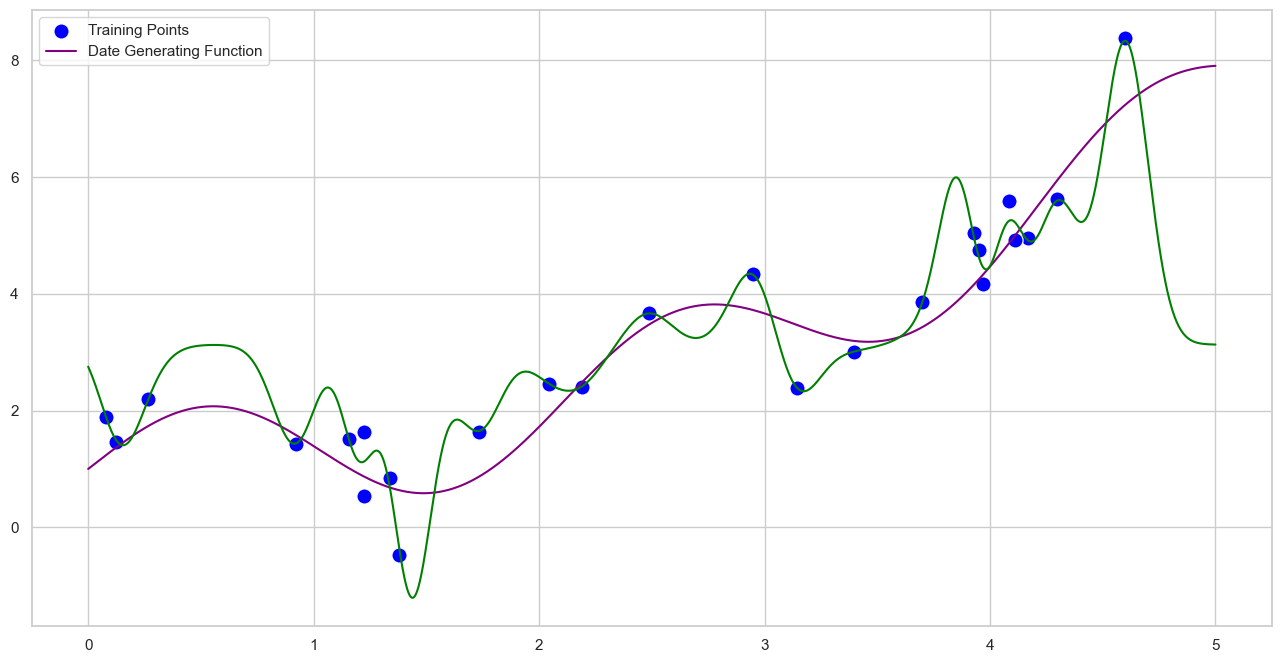

In [ ]:
x.shape

fig, ax = plt.subplots(figsize=(16, 8))
_ = sns.scatterplot(x=x_train.ravel(), y=y_train, color='blue', label="Training Points", s=POINT_SIZES, ax=ax)
_ = sns.lineplot(x=x_grid.ravel(), y=y_grid, color='purple', label="Data Generating Function", ax=ax)
_ = sns.lineplot(x=x_grid.ravel(), y=y_grid_hat, color='green', ax=ax)

## Create Dataset

In [6]:
def plot_random_data_and_model_preds(
        model_type: str='rbf',
        n_neighbours: int=1,
        kernel_scale: float=1.0,
        seed: int=123,
        fit: bool=False,
        show_test_points: bool=False,
        show_true_function: bool=False,
        y_noise_variance: float=0.0,
        n_training: int=30) -> None:
    """ Plots Randomly Sampled Data and Corresponding Model Fit 
        seed: int (random seed)
        fit: bool (whether to fit the model)
        show_test_points: whether to display the test points
        show_true_function: bool (whether to show the true function)
        y_noise_variance: variance of normally sampled noise to add to y
        n_training: number of samples to use for training
    """
    
    # Parameters
    x_max_range = 5
    num_grid_points = 600
    train_sample_proportion = 0.5
    point_sizes = 120
    
    # Sample Dataset
    n_samples = int(n_training / train_sample_proportion)
    x = np.linspace(0, x_max_range, n_samples).reshape(-1, 1)
    y_true = true_function(x) + 2
    y = np.clip(apply_noise(y_true, scale=y_noise_variance ** 2, seed=seed), 0, np.inf)


    # Train-Test Split
    indices = np.arange(0, x.shape[0])
    x_train, x_test, y_train, y_test, i_train, i_test = model_selection.train_test_split(
        x, y, indices, random_state=seed, train_size=n_training)
    
    # ML Pipeline
    if model_type == 'rbf':
        kernel = RBF(length_scale=kernel_scale)
        model = Pipeline([
            ('gp', GaussianProcessRegressor(kernel=kernel, alpha=0.01, optimizer=None, normalize_y=True))
        ])
    elif model_type == 'knn':
        model = Pipeline([
            ('knn', KNeighborsRegressor(n_neighbors=n_neighbours))
        ])

    # Plotting
    x_grid = np.linspace(0, x_max_range, num_grid_points).reshape(-1, 1)
    sns.set(rc={'figure.figsize':(16,8)})
    sns.set_theme(context='notebook', style='whitegrid', palette='deep')
    #sns.set()
    ax = sns.scatterplot(x=x_train[:,0], y=y_train, color='blue', label="Training Points", s=point_sizes)

    if show_test_points:
        ax = sns.scatterplot(x=x_test[:,0], y=y_test, color='red', label="Test Points", s=point_sizes)

    title = ''

    if fit:
        model = model.fit(X=x_train, y=y_train)
        y_pred_grid = model.predict(X=x_grid)
        y_pred = model.predict(X=x)
        ax = sns.lineplot(
            x=x_grid[:,0], y=y_pred_grid, color='green', ax=ax)
        mse_train = metrics.mean_squared_error(y[i_train], y_pred[i_train])
        title += f"MSE Train:{mse_train:.2f}"
        if show_test_points:
            mse_test = metrics.mean_squared_error(y[i_test], y_pred[i_test])
            title += f" | MSE Test:{mse_test:.2f}"

    if show_true_function:
        ax = sns.lineplot(x=x[:,0], y=y_true, color='purple', ax=ax)
        if fit:
            mse_true = metrics.mean_squared_error(y_true, y_pred)
            title += f"MSE true: {mse_true:.2f}"

    plt.title("Bias Variance Trade-Off\n" + title)

    ax.set(xlabel="X", ylabel = "Y")
    ax.set_ylim(1, 10)
    ax.set_xlim(0, 5)
    plt.show()

In [ ]:
kwargs = {
    'model_type': widgets.Dropdown(options=['rbf', 'knn']),
    'kernel_scale': widgets.FloatSlider(value=0.01, min=0.01, max=3, step=0.05),
    'n_neighbours': widgets.IntSlider(0, 1, 20),
    'seed': widgets.IntSlider(0, 1, 10),
    'fit': False,
    'show_test_points': False,
    'show_true_function': False,
    'y_noise_variance': widgets.FloatSlider(value=0.5, min=0.0, max=1.5, step=0.1),
    'n_training': widgets.IntSlider(value=15, min=5, max=100, step=5)}

In [8]:
_ = widgets.interact(plot_random_data_and_model_preds, **kwargs)

interactive(children=(Dropdown(description='model_type', options=('rbf', 'knn'), value='rbf'), IntSlider(value…

## Case 2) Large Dataset with Redundant Features

In [73]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [74]:
NUM_SAMPLES = 20_000
NUM_TRAINING = 5000
X, y = make_classification(n_samples=NUM_SAMPLES, n_features=40, n_informative=4, n_classes=2, weights=[0.9, 0.1], random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=NUM_TRAINING, random_state=RANDOM_SEED)

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

In [76]:
algorithms = {
    "random_forest": {
        "cls": RandomForestClassifier,
        "hyper_params": {
            "cls__n_estimators": [50, 100, 200],
            "cls__max_depth": [1, 3, 5, 10, 15]
        }
    }
}

In [79]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

metric = "accuracy"

for model_name, (model_data) in algorithms.items():
    print(f"Optimizing {model_name}...")

    pipeline = Pipeline([
        ("cls", model_data["cls"]())
    ])

    param_grid = model_data["hyper_params"]


    search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1,
    )

    search.fit(X_train, y_train)

Optimizing random_forest...


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('cls', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cls__max_depth': [1, 3, 5, 10, 15],
                         'cls__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [81]:
search.cv_results_
search.best_params_

{'mean_fit_time': array([0.22548326, 0.40543644, 0.80790957, 0.45630622, 0.95908864,
        2.06578628, 0.68261298, 1.64400752, 3.27367226, 1.1431582 ,
        2.15917206, 3.66327945, 1.40945999, 2.10736108, 3.6145707 ]),
 'std_fit_time': array([0.012004  , 0.01327219, 0.05767276, 0.01120764, 0.0434979 ,
        0.33289985, 0.03933338, 0.37251416, 0.140747  , 0.23540251,
        0.55696339, 0.17070673, 0.54758846, 0.34893149, 0.30843408]),
 'mean_score_time': array([0.00771308, 0.00848913, 0.01995158, 0.00715939, 0.01365217,
        0.02786771, 0.0090371 , 0.00996447, 0.02029649, 0.00862726,
        0.01686645, 0.01869647, 0.0114816 , 0.01592771, 0.02225804]),
 'std_score_time': array([0.00198008, 0.00015709, 0.00383554, 0.00106859, 0.00374415,
        0.00103128, 0.00134051, 0.00225067, 0.00643832, 0.00245648,
        0.0040143 , 0.00045701, 0.00328393, 0.00127964, 0.00034654]),
 'param_cls__max_depth': masked_array(data=[1, 1, 1, 3, 3, 3, 5, 5, 5, 10, 10, 10, 15, 15, 15],
          

{'cls__max_depth': 15, 'cls__n_estimators': 200}

In [ ]:
# Define models and hyperparameters
models = {
    "random_forest": (RandomForestClassifier(), {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__max_depth": [None, 10, 20],
        "classifier__min_samples_split": [2, 5],
        "preprocessor": preprocessing_options
    }),
    "svm": (SVC(), {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["linear", "rbf"],
        "preprocessor": preprocessing_options
    }),
    "logistic_regression": (LogisticRegression(), {
        "classifier__C": [0.1, 1, 10],
        "classifier__solver": ["liblinear"],
        "preprocessor": preprocessing_options
    }),
    "xgboost": (XGBClassifier(use_label_encoder=False, eval_metric="logloss"), {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__max_depth": [3, 6, 10],
        "classifier__learning_rate": [0.01, 0.1, 0.3],
        "preprocessor": preprocessing_options
    }),
}

(5000, 40)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from skopt import BayesSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin

# Dummy Transformer for "no preprocessing" option
class IdentityTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X

# Load dataset (replace with actual dataset)
df = pd.read_csv("your_dataset.csv")  # Replace with your file
X = df.drop(columns=["target"])  # Replace 'target' with actual target column
y = df["target"]

# Handle missing values
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing options
preprocessing_options = [
    ("none", IdentityTransformer()),
    ("standard_scaler", StandardScaler()),
    ("minmax_scaler", MinMaxScaler()),
    ("pca_5", PCA(n_components=5))
]

